In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
import Colors
import JLD
import PyCall
import FileIO

## load the Snap results

In [2]:
rasterio = PyCall.pyimport("rasterio");

In [3]:
snap_tiff = rasterio.open("/Users/simon/Data/Sentinel/vejle_oktober/snap_result_test2/vejle_subset_insar_snap_TC.tif");
transform = snap_tiff.get_transform()
rows = collect(1:snap_tiff.height).-1;
columns = collect(1:snap_tiff.width).-1;
snap_lon = transform[1] .+ rows .* transform[2];
snap_lat = transform[4] .+ columns .* transform[6];

In [4]:
snap_coh = snap_tiff.read(1);
FileIO.save("test.jpg",Colors.Gray.(snap_coh));

## Get own results

In [5]:
folder = "/Users/simon/Data/Sentinel/vejle_oktober/factory_ABA"
own_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")
FileIO.save("test2.jpg",Colors.Gray.(abs.(own_gamma)));

In [6]:
line_sample = JLD.load(joinpath(folder,"line_sample.jld"))
samples = convert.(Int,collect(line_sample["samples"])) #[1:7:end]
lines = convert.(Int,collect(line_sample["lines"])) #[1:2:end]
lut = JLD.load(joinpath(folder,"21_lut.jld"),"data");

In [7]:
own_lat = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["latitude"],(length(lut["master_line"]),length(lut["master_sample"])))
, lines,samples)
own_lon = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
reshape(lut["longitude"],(length(lut["master_line"]),length(lut["master_sample"])))
,lines,samples);

In [8]:
size(own_lat)

(909, 683)

In [9]:
size(own_gamma)

(909, 683)

## Resample snap results

In [10]:
ndimage = PyCall.pyimport("scipy.ndimage");

In [11]:
idx1 = reshape((own_lat.-transform[4])./(transform[6]),:)
idx2 = reshape((own_lon.-transform[1])./transform[2],:);
index = [idx1,idx2];

In [12]:
index 

2-element Array{Array{Float64,1},1}:
 [3235.76, 3233.79, 3231.81, 3229.84, 3227.86, 3225.89, 3223.91, 3221.94, 3219.96, 3217.99  …  1264.35, 1262.38, 1260.4, 1258.43, 1256.46, 1254.48, 1252.5, 1250.51, 1248.53, 1246.55] 
 [673.106, 672.545, 671.979, 671.407, 670.834, 670.257, 669.674, 669.091, 668.506, 667.918  …  2236.9, 2236.31, 2235.72, 2235.14, 2234.57, 2234.04, 2233.54, 2233.05, 2232.55, 2232.03]

In [13]:
snap_coh_re = ndimage.map_coordinates(snap_coh, index, order=1, mode="constant");
snap_coh_re= reshape(snap_coh_re,size(own_gamma));

In [14]:
FileIO.save("test_re.jpg",Colors.Gray.(snap_coh_re));

## Compare

In [53]:
img = Colors.RGB{Float32}.(abs.(own_gamma),snap_coh_re,snap_coh_re);
FileIO.save("ownSnapSnap.jpg",img);

In [54]:
diff = abs.(abs.(own_gamma).- snap_coh_re)
diff[snap_coh_re .==0] .=0
FileIO.save("diff.jpg",Colors.Gray.(diff./2));


In [55]:
using Statistics
using Plots

In [ ]:
diff = (abs.(own_gamma).- snap_coh_re)
diff = reshape(diff,:)
diff = diff[reshape(snap_coh_re,:) .!=0];

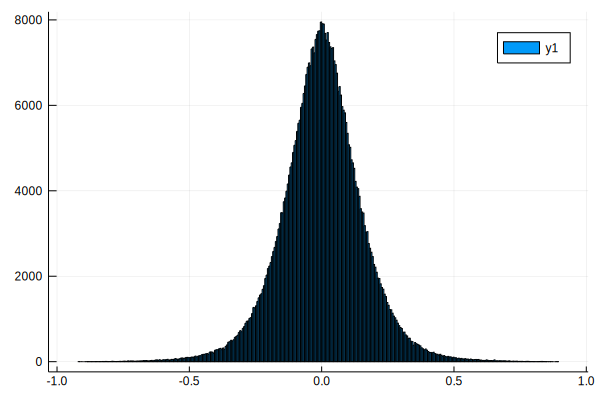

In [27]:
histogram(diff)

In [28]:
mean(diff)

0.001439148107655792

## Test with small ofset

In [50]:
offset = 1

1

In [51]:
diff = (abs.(own_gamma[:,1+offset:end]).- snap_coh_re[:,1:end-offset])
diff = reshape(diff,:)
diff = diff[reshape(snap_coh_re[:,1:end-offset],:) .!=0];

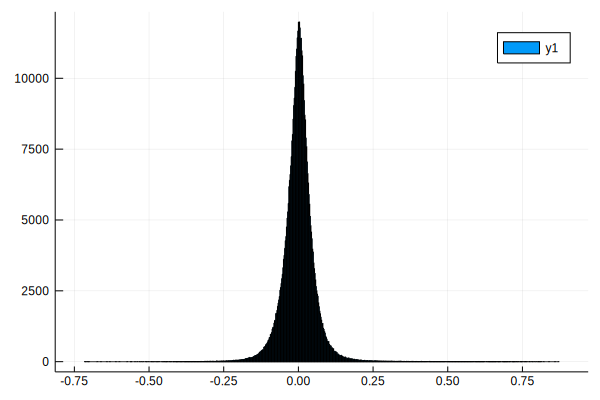

In [52]:
histogram(diff)

In [ ]:
diff = (abs.(own_gamma[:,1+offset:end]).- snap_coh_re[:,1:end-offset])
diff = reshape(diff,:)
diff = diff[reshape(snap_coh_re[:,1:end-offset],:) .!=0];

### Sigma 0

In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
import Colors
import JLD
import PyCall
import FileIO

In [4]:
rasterio = PyCall.pyimport("rasterio");
function db_scale_img(img , min , max)
    log_img = (10*log10.(img).-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end

db_scale_img (generic function with 1 method)

In [6]:
snap_tiff = rasterio.open("/Users/simon/Data/Sentinel/vejle_oktober/snap_result_test2/subset_2_of_subset_1_of_S1A_IW_SLC__1SDV_20191011T170932_20191011T170959_029414_035865_06AB_deb_Cal_TC.tif");
transform = snap_tiff.get_transform()
rows = collect(1:snap_tiff.height).-1;
columns = collect(1:snap_tiff.width).-1;
snap_lon = transform[1] .+ rows .* transform[2];
snap_lat = transform[4] .+ columns .* transform[6];

In [7]:
min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

-3

In [9]:
bands = [snap_tiff.read(i) for i in 1:2]

2-element Array{Array{Float32,2},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [13]:
test = log10.(bands[1] .+ 10^(-5));

In [14]:
maximum(test)

2.0782817753133283

In [23]:
img = Colors.Gray.(db_scale_img(bands[1].+ 10^(-5),min_vv,max_vv));
FileIO.save("test_int.jpg",img );